# Tutorial Notebook for Polarimetric Observation Functionalities

Currently a simple polarimeter is implemented consisting of a half-wave plate upstream of a Wollaston prism. These effects are taken into account with a measurement matrix, the product of each components Mueller matrix form. To correctly apply polarizing effects to the model spectra, inputs are expected to be 4xN Stokes vectors of the form $S_{in} = [I, Q, U, V]$.

Functionality for generating measurement matrices for the system can be called at desired half-wave plate angles. User defined measurement matrices may also be used given that they are 4x4 and follow Mueller calculus.

Direct ouputs of the observation function are ordinary and extraordinary beams split from the Wollaston prism. They maintain their 4xN shape, but it should be noted the detector only "sees" the zeroth component. 

Recovery of the desired Stokes parameter can be down through inversion of the measurement matrices or through double-differencing. Both methods will be shown in this notebook.

Note: circular polarization is currently untracked but is simple to add into this code.

---

Import all necessary functions.

In [1]:
from psisim import telescope,instrument,observation,spectrum,universe,plots,signal
import time
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from importlib import reload
import speclite.filters
from scipy.interpolate import interp1d, RegularGridInterpolator as rgi
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings("ignore")

# SMALL_SIZE = 32
# MEDIUM_SIZE = 40
# BIGGER_SIZE = 48

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/opt/anaconda3/lib/python3.8/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/opt/anaconda3/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


Tried importing picaso, but couldn't do it


## Set up telescope, instrument, target properties, and the model Stokes Vector.

---

For simplicity, we will assume the source only has linear polarized intensity that is a scaled down, doppler shifted version of the total intensity spectrum.  This has similarities to a large, close in exoplanet orbiting around a host star, but in this case the contrast is much higher for demonstration purposes.  We'll let the $45^{\circ}$ polarization component be similar but with a different rv.

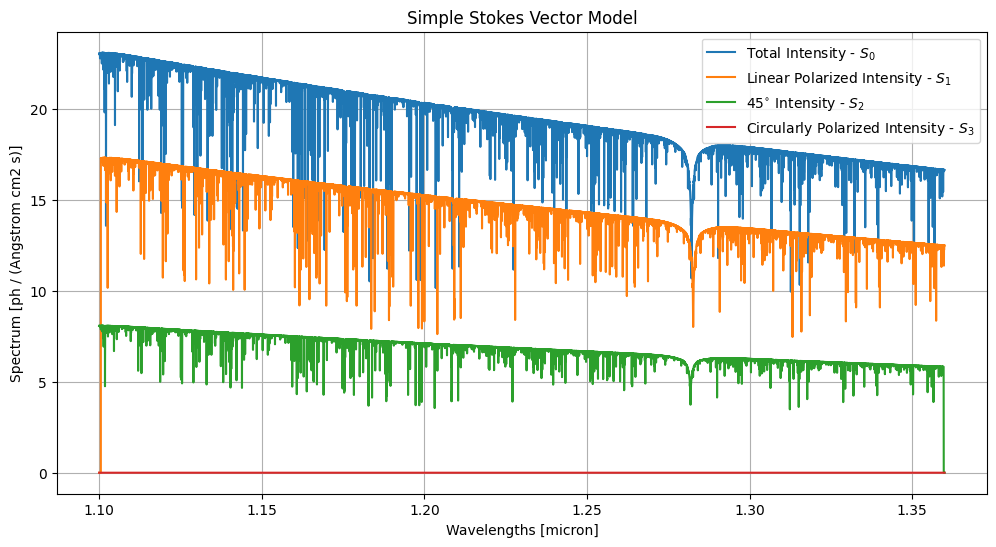

In [2]:
path = '/Users/connorvancil/Astro/psisim/psisim/data/'
model_path='/Users/connorvancil/Astro/'
filters = spectrum.load_filters()
keck = telescope.Keck(path=path)
keck.airmass=1.0
keck.water_vapor=1.6
keck.seeing = keck.median_seeing

#Initialize a kpic object and set the current filter
hispec = instrument.hispec(telescope=keck)
hispec.set_current_filter("TwoMASS-J")

#Get the set of wavelengths based on the current instrument setup
wavelengths = hispec.get_wavelength_range()

# Set the observing mode: Exposure time (per exposure), Number of Exposures,filter name, wavelength array
hispec.set_observing_mode(360,1,'TwoMASS-J', wavelengths ,mode="on-axis") 

#First set the host properties for a Phoenix model. 
host_properties = {"StarLogg":4.00*u.dex(u.cm/ u.s**2),"StarTeff":6500*u.K,"StarZ":'-0.0',"StarAlpha":"0.0",
                   "StarRadialVelocity":0*u.km/u.s, "StarVsini":1*u.km/u.s,"StarLimbDarkening":0.6}

#Now setup the user parameters that a Phoenix model needs: (path, object_filter, magnitude_in_object_filter,
# filters_object,current_filter). 
host_user_params = (model_path,'TwoMASS-J',2.5,filters,hispec.current_filter)
host_properties["StarAOmag"] = spectrum.get_model_ABmags(host_properties,[hispec.ao_filter], model='Phoenix',verbose=False,user_params = host_user_params)
hispec.ao_mag = host_properties["StarAOmag"];host_properties['StarSpT'] = None

I_spectrum = spectrum.get_stellar_spectrum(host_properties,wavelengths,hispec.current_R,model="Phoenix",
                                              user_params=host_user_params,doppler_shift=True,broaden=True,
                                              delta_wv=hispec.current_dwvs)

Q_spectrum = spectrum.Spectrum(wavelengths, 0.75*I_spectrum.spectrum, hispec.current_R)
Q_spectrum.apply_doppler_shift(hispec.current_dwvs, 125)

U_spectrum = spectrum.Spectrum(wavelengths, 0.35*I_spectrum.spectrum, hispec.current_R)
U_spectrum.apply_doppler_shift(hispec.current_dwvs, -75)

Example_Stokes = np.array([I_spectrum.spectrum,Q_spectrum.spectrum,U_spectrum.spectrum,np.zeros(len(I_spectrum.spectrum))]) * I_spectrum.spectrum.unit

plt.figure(figsize=(12,6))
plt.plot(wavelengths, Example_Stokes[0], label = r'Total Intensity - $S_0$')
plt.plot(wavelengths, Example_Stokes[1], label = r'Linear Polarized Intensity - $S_1$')
plt.plot(wavelengths, Example_Stokes[2], label = r'$45^{\circ}$ Intensity - $S_2$')
plt.plot(wavelengths, Example_Stokes[3], label = r'Circularly Polarized Intensity - $S_3$')
plt.xlabel("Wavelengths [{}]".format(wavelengths.unit));plt.ylabel("Spectrum [{}]".format(Example_Stokes.unit))
plt.title("Simple Stokes Vector Model")
plt.legend();plt.grid()



## Generate Measurement Matrices

---

For example purposes, an observation to recover the linear polarization of the input Stokes vector will be computed. 



For a general half-wave plate angle $\theta$, the polarization of the Stokes vector gets rotated by $2\theta$. Our measurement matrix to determine linear polarization should then be:

$$ M = M(-2\theta)M_{woll}M(2\theta) $$
$$ M = \begin{pmatrix}
1 & 0 & 0 & 0\\ 1 & cos(2\theta) & -sin(2\theta) & 0\\ 0 & sin(2\theta) & cos(2\theta) & 0\\ 0 & 0 & 0 & -1\end{pmatrix}\begin{pmatrix}
1 & \pm 1 & 0 & 0\\ \pm 1 & 1 & 0 & 0\\ 0 & 0 & 0 & 0\\ 0 & 0 & 0 & 0\end{pmatrix}
\begin{pmatrix}
1 & 0 & 0 & 0\\ 1 & cos(2\theta) & sin(2\theta) & 0\\ 0 & -sin(2\theta) & cos(2\theta)& 0\\ 0 & 0 & 0 & -1\end{pmatrix}
$$

$$
M = 
\begin{pmatrix}
1 & \pm cos(2\theta) & \pm sin(2\theta) & 0\\ \pm cos(2\theta) & cos^2(2\theta) & sin(2\theta)cos(2\theta) & 0\\ \pm sin(2\theta) & sin(2\theta)cos(2\theta) & sin^2(2\theta)& 0\\ 0 & 0 & 0 & 0\end{pmatrix}

$$

So, if $S_{model} = [S_0,S_1,S_2,S_3]$
$$S_{observed} = MS_{in}$$

$$S_{out} = \begin{pmatrix}
S_0 \pm cos(2\theta)S_1 \pm sin(2\theta)S_2 \\ \pm cos(2\theta)S_0 + cos^2(2\theta)S_1 + cos(2\theta)sin(2\theta)S_2 \\ \pm sin(2\theta)S_0 + cos(2\theta)sin(2\theta)S_1 + sin^2(2\theta)S_2 \\0
\end{pmatrix}
$$

For the simple cases, we see:
$$ S_{observed}(\theta = \frac{\pi}{2}) = \begin{pmatrix} S_0 \mp S_1 \\ \mp S_0 + S_1 \\0\\0\end{pmatrix}  $$
 
$$ S_{observed}(\theta = \frac{\pi}{4}) = \begin{pmatrix} S_0 \pm S_2 \\ 0\\ \pm S_0 + S_2 \\0\end{pmatrix}  $$

Recovering the desired Stokes Parameter can be done easily with double-differencinng (in the simple case) or measurement matrix pseudo-inversion.

From the above equations, we can see 

$$ S_{recovered}(\theta = \frac{\pi}{2}) = -\frac{S_{out}^o-S_{out}^e}{2}  = \begin{pmatrix} S_1 \\S_0\\0\\0\end{pmatrix}$$

$$ S_{recovered}(\theta = \frac{\pi}{4}) = \frac{S_{out}^o-S_{out}^e}{2}  = \begin{pmatrix} S_2 \\0\\S_0\\0\end{pmatrix}$$

$$ S_{recovered}(\theta) = M^{-1}S_{observed} = M^{-1}MS_{model} $$

Recall that the instrument can only see $S_0$ the total intensity component, so in the described method above, we recover $S_1$ for $\theta = \pi/2$ and $S_2$ for $\theta = \pi/4$. 

To recover $S_3$, or circular polarization, would require a quarter wave plate which I haven't coded up just yet. The quarter waveplate converts elliptical polarization into linear polarization, which then gets split by the wollaston prism and read off in the same manor as the othrer lineaer polarization components.

---

Note that if M is not-invertible, the pseudo-inverse of M must be used and the solution won't be exact. Carrying out the math shows that 

$$M^{\dagger} = \frac{1}{(cos^2(2\theta) + sin^2(2\theta)+1)^2}
\begin{pmatrix}
1 & \pm cos(2\theta) & \pm sin(2\theta) & 0\\ \pm cos(2\theta) & cos^2(2\theta) & sin(2\theta)cos(2\theta) & 0\\ \pm sin(2\theta) & sin(2\theta)cos(2\theta) & sin^2(2\theta)& 0\\ 0 & 0 & 0 & 0\end{pmatrix} = \frac{1}{4}M
$$

Applying this back on $S_{observed}$ only tells you about some combinations of model's linear polarization states.

---

In [3]:
Muellers = observation.generate_muellers("Q",n_cycles=1)
print("Ordinary Beam:",'\n',"{}".format(np.round(Muellers[0],2)))
print("Extraordinary Beam:",'\n',"{}".format(np.round(Muellers[1],2)))

Ordinary Beam: 
 [[ 0.5 -0.5  0.   0. ]
 [-0.5  0.5 -0.   0. ]
 [ 0.  -0.   0.   0. ]
 [ 0.   0.   0.   0. ]]
Extraordinary Beam: 
 [[ 0.5  0.5 -0.   0. ]
 [ 0.5  0.5 -0.   0. ]
 [-0.  -0.   0.   0. ]
 [ 0.   0.   0.   0. ]]


## Conduct the Observation

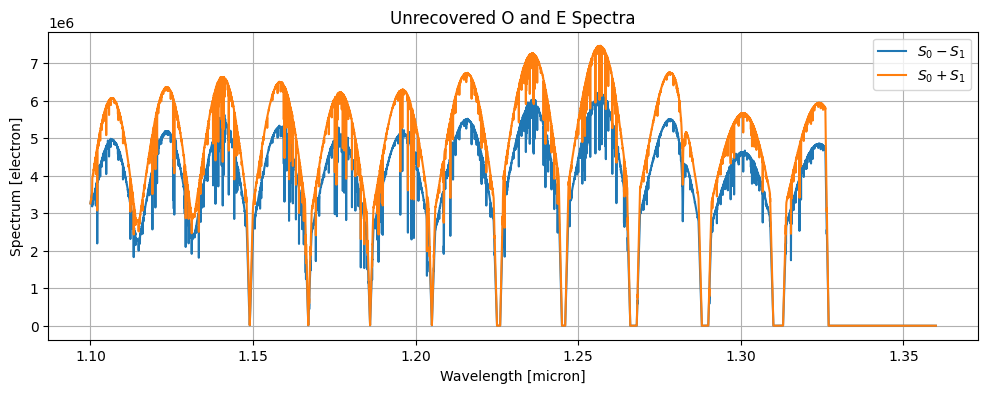

In [4]:
S_obs, total_noise, thermal_flux, Muellers = observation.simulate_stokes_observation(keck, hispec, Example_Stokes, wavelengths,
                                                stokes_param="Q", Muellers = Muellers, sky_on = False, inject_noise= False, apply_lsf = True )
plt.figure(figsize=(12,4))
plt.plot(wavelengths, S_obs[0], label = r'$S_0 - S_1$')
plt.plot(wavelengths, S_obs[1], label = r'$S_0 + S_1$')
plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(S_obs.unit))
plt.title("Unrecovered O and E Spectra")
plt.legend();plt.grid()                                            

As we can see, the two beams dont tell us much about the polarization unless we recombine them. In this case to recover $S_1$ we use $$S_1 = \frac{S_e - S_o}{2}$$

$$and$$ 

$$S_0 = \frac{S_o+S_e}{2}$$

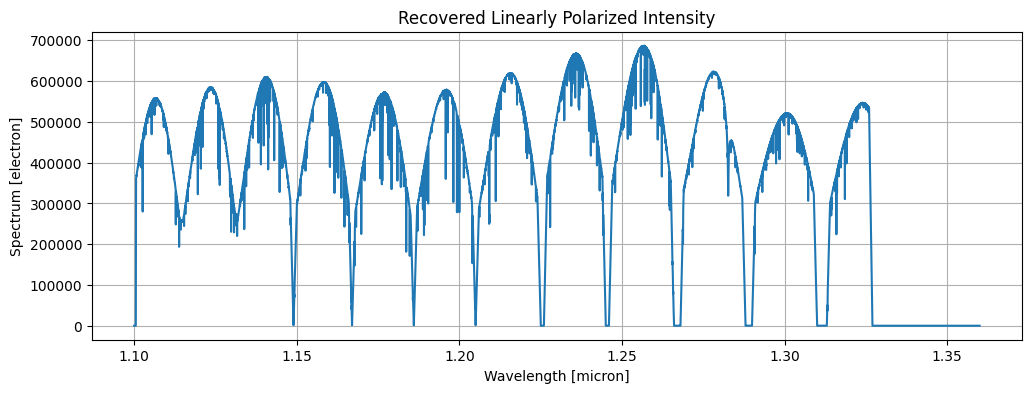

In [5]:
recovered_Q = -(S_obs[0] - S_obs[1])/2
recovered_I = (S_obs[0] + S_obs[1])/2
plt.figure(figsize=(12,4))
plt.plot(wavelengths, recovered_Q)
plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(S_obs.unit))
plt.title("Recovered Linearly Polarized Intensity")
plt.grid()


---

# Verify the Recovered Spectrum Through RV-CCF

Since the polarized intensities were rv-shifted with respect to the total intensity, we should be able to verify the recovered spectrum is $S_1$ through cross correlation.

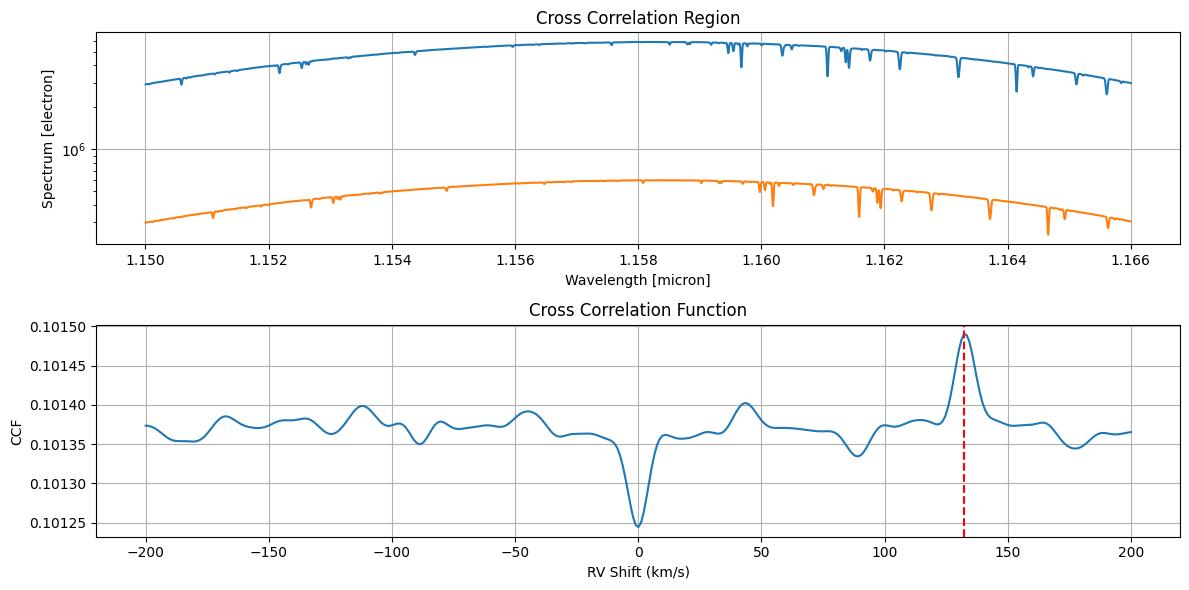

In [6]:
from PyAstronomy import pyasl

# Only use part of the spectrum for cross correlation
wvmin, wvmax = (1.15,1.166)
ind = np.where((wavelengths.value >= wvmin) & (wavelengths.value <= wvmax))[0]
wvccf = wavelengths[ind]
iccf, qccf = recovered_I[ind], recovered_Q[ind]

rv, cc = pyasl.crosscorrRV(wvccf, qccf.value, wvccf, iccf.value, -200, 200, .1, skipedge = 750, mode='doppler')
rv, ac = pyasl.crosscorrRV(wvccf, iccf.value, wvccf, iccf.value, -200, 200, .1, skipedge = 750, mode='doppler')

fig, ax = plt.subplots(2,figsize=(12,6))

ax[0].semilogy(wvccf,iccf,label="Total Intensity")
ax[0].semilogy(wvccf, qccf, label="Linearly Polarized Intensity")
ax[0].set_xlabel("Wavelength [{}]".format(wavelengths.unit));ax[0].set_ylabel("Spectrum [{}]".format(recovered_I.unit));
ax[0].set_title("Cross Correlation Region");ax[0].grid()


# Here I am normalizing by the autocorrelation so the high-rv peak is more apparent 
# The minimum at zero rv is a result of this division and can be ignored

ax[1].plot(rv,cc/ac)
ax[1].axvline(rv[np.argmax(cc/ac)],c='r', ls='--')
# ax[1].text(-200,0.75,"Recovered Degree of Polarization: {:.2f}".format(np.nanmedian(recovered_Q/recovered_I)))
ax[1].set_xlabel("RV Shift (km/s)");ax[1].set_ylabel("CCF");ax[1].set_title("Cross Correlation Function")
plt.tight_layout();ax[1].grid()

We can see then the RV returned is near our injected RV in $S_1$. So the component we are looking at is in fact $S_1$. This technique does not necessarily need to be preformed but illustrates the validity of the simple recovery method.